In [1]:
import ee
import datetime
import os
import itertools
import sys

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('../Process_1_GEE_Python_Classification/')

# import the temporal_consistency_check class
from BackGround_modules.Class_5_Temporal_consistency_check import Temporal_consistency_check

In [4]:
# define basic parameters
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

In [5]:
year_range

['1990_1992',
 '1993_1995',
 '1996_1998',
 '1999_2001',
 '2002_2004',
 '2005_2007',
 '2008_2010',
 '2011_2013',
 '2014_2016',
 '2017_2019']

### Import Classified_random_img and Check_sample

In [6]:
# Define the threshold for sum_img of 10 classifications
Threshold_sum_classificatioin = 5

# import the classified imgs,note here we left the last 2 classification of Classified_Landsat_1990_2019 
# beacuse their accuracy are too low
Classified_Landsat_1990_2019  = [ee.ImageCollection(f"users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_{year}")
                                  .sum().gt(Threshold_sum_classificatioin).set('name',year)   for year in year_range[:-2]]

Classified_Sentinel_2014_2019 = [ee.ImageCollection(f"users/wangjinzhulala/North_China_Plain_Python/classification_img/Sentinel_Landsat_{year}")
                                  .sum().gt(Threshold_sum_classificatioin).set('name',year)   for year in year_range[-2:]]

# merge the classified img together
Classified_imgs = Classified_Landsat_1990_2019 + Classified_Sentinel_2014_2019

In [7]:
# import the untouched control points, which are diveded by a random column with a 101 random state
Sample_Landsat  = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Control_points")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)

Sample_Sentinel = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Sentinel_2017_2019")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)

### Perform temporal consistency check

In [8]:
# get the checked results
Iteration_num = 10
Window_size = [2,3,4,5,6]
modes = ['backward_forward','forward_backward','only_forward','only_backward']

Check_df_list = []

for window in Window_size:
    for mode in modes:
    
        # get the checked classification imgs, here they are stored in a dictionary
        Iter_temporal_check_instaces = Temporal_consistency_check(Classified_imgs,window,Iteration_num)\
                                        .Iterate_the_check(mode = mode)

        # convert the Iter_temporal_check_instaces to a Dataframe
        Check_instances = pd.DataFrame(Iter_temporal_check_instaces).T
        Check_instances.columns = year_range

        # Add the window-size and iteration-num to the df
        Check_instances['Mode'] = mode * Iteration_num
        Check_instances['Window'] = [window] * Iteration_num
        Check_instances['Iteration'] = range(1,Iteration_num+1)

        # Reorder the columns
        cols = Check_instances.columns
        Check_instances = Check_instances[list(cols[-3:]) + list(cols[:-3])] 

        # add the checked df into list
        Check_df_list.append(Check_instances)

================  Check Report  ================
Check length is    ---> 2
Check weights are  ---> [2, 1]
Check threshold is ---> 3
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 2
Check weights are  ---> [2, 1]
Check threshold is ---> 3
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 2
Check weights are  ---> [2, 1]
Check threshold is ---> 3
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 2
Check weights are  ---> [2, 1]
Check threshold is ---> 3
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 3
Check weights are  ---> [3, 1, 1]
Check threshold is ---> 4
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 3
Check weights are  ---> [3, 1, 1]
Check threshold is ---> 4
Check iteration is ---> 10
================  Check Report  ========

In [ ]:
# merge all instace_df together
Check_df = pd.concat(Check_df_list)
Check_df.reset_index(inplace=True,drop=True)

# add the original classification_img to the df
Check_df.loc[-1] = [0,0,0] + Classified_imgs
Check_df.index = Check_df.index + 1  # shifting index
Check_df.sort_index(inplace=True) 

Check_df

### Assess the accuracy after the temporal check

##### Transform the Check_sample into long format so each row is an observation with spicific window-iteration-year condition

In [30]:
# create sample list for accuracy assesment
Check_sample = [Sample_Landsat] * len(Classified_Landsat_1990_2019) + \
               [Sample_Sentinel] * len(Classified_Sentinel_2014_2019)

Sample_size = [Sample_Landsat.size().getInfo()]  * len(Classified_Landsat_1990_2019) + \
              [Sample_Sentinel.size().getInfo()] * len(Classified_Sentinel_2014_2019)

In [35]:
# attach Check_sample to the Check_instaces_long 
Check_instaces_long = pd.DataFrame(Check_df.set_index(['Window','Iteration']).stack()).reset_index()
Check_instaces_long.columns = ['Window','Iteration','year','Image']

In [38]:
# add check_sample and sample_size for later accuracy assessment
Check_instaces_long['Check_sample'] = Check_sample * ( len(Window_size)* (Iteration_num) + 1)
Check_instaces_long['Sample_size']  = Sample_size *  ( len(Window_size)* (Iteration_num) + 1)

# extract checked_img pixel value to sample
Check_instaces_long['Sample_extract_img_value'] = Check_instaces_long.apply(lambda x: ee.Image(x['Image'])\
                                                                                         .sampleRegions(collection = x['Check_sample'], 
                                                                                                        properties = ['Built'], 
                                                                                                        scale      = 30),1)

Check_instaces_long

,Window,Iteration,year,Image,Check_sample,Sample_size,Sample_extract_img_value
0,0,0,1990_1992,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""..."
1,0,0,1993_1995,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""..."
2,0,0,1996_1998,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""..."
3,0,0,1999_2001,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""..."
4,0,0,2002_2004,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""..."
...,...,...,...,...,...,...,...
255,6,5,2005_2007,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""..."
256,6,5,2008_2010,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""..."
257,6,5,2011_2013,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,"ee.FeatureCollection({\n ""type"": ""Invocation""..."
258,6,5,2014_2016,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...",2017,"ee.FeatureCollection({\n ""type"": ""Invocation""..."


In [42]:
chunk_size = 10
correct_num_list = []

# chop the featurecollection into several sub-list, so we can apply map function
# to decrease the computation time
for i in range(0,len(Check_instaces_long),chunk_size):
    
    # chop the fe_col with at the length of chunk_size
    sample_ext_img =  list(Check_instaces_long['Sample_extract_img_value'][i:i+chunk_size])
    
    # covert the fe_col into a ee.List
    sample_ext_img_list = ee.List(sample_ext_img)
    
    # get the value
    correct_num =  sample_ext_img_list.map(lambda x: ee.FeatureCollection(x)\
                                                        .filter(ee.Filter.equals('Built',None,'classification')).size())\
                                                        .getInfo()
    
    # add the correct_num to list
    correct_num_list.extend(correct_num)
    
    # print out the process
    print(f'{i+chunk_size}/{len(Check_instaces_long)} finished!')

10/260 finished!
20/260 finished!
30/260 finished!
40/260 finished!
50/260 finished!
60/260 finished!
70/260 finished!
80/260 finished!
90/260 finished!
100/260 finished!
110/260 finished!
120/260 finished!
130/260 finished!
140/260 finished!
150/260 finished!
160/260 finished!
170/260 finished!
180/260 finished!
190/260 finished!
200/260 finished!
210/260 finished!
220/260 finished!
230/260 finished!
240/260 finished!
250/260 finished!
260/260 finished!


##### Compute the accuracy after temporal-check

In [99]:
# Calculate the checked accuracy
Checked_acc = Check_instaces_long[['Window','Iteration','year']].copy()
Checked_acc['Accuracy'] = np.array(correct_num_list)/Check_instaces_long['Sample_size']*100

# Save the accuracy to disk
Checked_acc.to_csv('./Result/Temporal_check_acc.csv',index=False)

# load the acc_df
Checked_acc = pd.read_csv('./Result/Temporal_check_acc.csv')

# concert these columns into category, so we can make figures
Checked_acc['Iteration'] = Checked_acc['Iteration'].astype('category')
Checked_acc['year'] = Checked_acc['year'].astype('category')

In [123]:
Checked_acc

,Window,Iteration,year,Accuracy
0,0,0,1990_1992,99.090909
1,0,0,1993_1995,99.141414
2,0,0,1996_1998,99.191919
3,0,0,1999_2001,98.888889
4,0,0,2002_2004,98.787879
...,...,...,...,...
255,6,5,2005_2007,99.393939
256,6,5,2008_2010,99.494949
257,6,5,2011_2013,99.090909
258,6,5,2014_2016,98.611800


##### Observe that there are no differences in accuracy during temporal consistency check among iterations

In [125]:
Checked_acc.groupby(['year','Window']).std()

Accuracy
year      Window          
1990_1992 0            NaN
          2            0.0
          3            0.0
          4            0.0
          5            0.0
          6            0.0
1993_1995 0            NaN
          2            0.0
          3            0.0
          4            0.0
          5            0.0
          6            0.0
1996_1998 0            NaN
          2            0.0
          3            0.0
          4            0.0
          5            0.0
          6            0.0
1999_2001 0            NaN
          2            0.0
          3            0.0
          4            0.0
          5            0.0
          6            0.0
2002_2004 0            NaN
          2            0.0
          3            0.0
          4            0.0
          5            0.0
          6            0.0
2005_2007 0            NaN
          2            0.0
          3            0.0
          4            0.0
          5            0.0
          6            0.0
2008_2010 0            NaN
          2            0.0
          3            0.0
          4            0.0
          5            0.0
          6            0.0
2011_2013 0            NaN
          2            0.0
          3            0.0
          4            0.0
          5            0.0
          6            0.0
2014_2016 0            NaN
          2            0.0
          3            0.0
          4            0.0
          5            0.0
          6            0.0
2017_2019 0            NaN
          2            0.0
          3            0.0
          4            0.0
          5            0.0
          6            0.0

##### Observe that a window-size of 3 is the optimun size

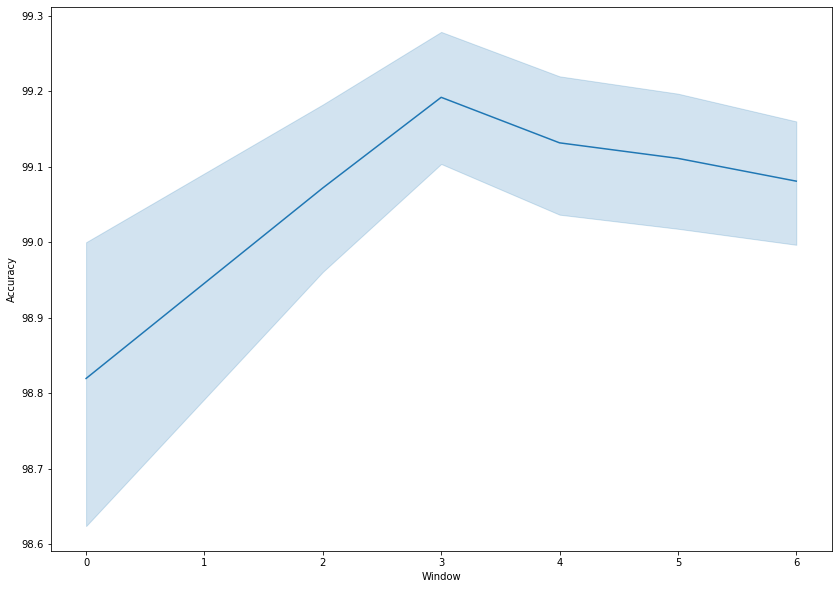

In [118]:
plt.figure(figsize=(14,10))
sns.lineplot(data = Checked_acc,x='Window',y='Accuracy' )

##### Export the imgs that being temporal-checked with a window size of 3

In [134]:
# get all checked img with window size of 3
classification_window_3 = Check_instaces_long[(Check_instaces_long['Window'] == 3)&\
                                              (Check_instaces_long['Iteration'] == 1)][['year','Image']]

# import the export region
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [135]:
for idx,row in classification_window_3.iterrows():
    
    year = row[0]
    img  = row[1]
    
    # determine the img name
    export_name = f'Temporal_checked_{year}'

    #export to GEE asset
    asset_path = 'users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked'
    
    task = ee.batch.Export.image.toAsset(   image          = img,
                                            description    = export_name,
                                            assetId        = f'{asset_path}/{export_name}',
                                            region         = North_China_Plain.geometry().bounds(),
                                            scale          = 30,
                                            maxPixels      = int(1e13)) 
    
    task.start()
    
    print(f'Exporting {export_name} successful!')

Exporting Temporal_checked_1990_1992 successful!
Exporting Temporal_checked_1993_1995 successful!
Exporting Temporal_checked_1996_1998 successful!
Exporting Temporal_checked_1999_2001 successful!
Exporting Temporal_checked_2002_2004 successful!
Exporting Temporal_checked_2005_2007 successful!
Exporting Temporal_checked_2008_2010 successful!
Exporting Temporal_checked_2011_2013 successful!
Exporting Temporal_checked_2014_2016 successful!
Exporting Temporal_checked_2017_2019 successful!


##### Add the checked img to the map

In [117]:
Map = geemap.Map()
Map.setCenter(115.4508, 35.2492,10)

# define filter parameters
window_len = 3
year_idx = '1990_1992'


# Get the imgs with specific year
img_year = Check_instaces_long[Check_instaces_long['year'] == year_idx]

# get the img with spcific window size
img_year_window = img_year[img_year['Window'] == window_len]

# get the un-checked img
img_year_original = img_year[img_year['Window'] == 0]['Image'].values[0]

# get the checked img with different iteration
img_year_window_it_1 = img_year_window[img_year_window['Iteration'] == 1]['Image'].values[0]
img_year_window_it_2 = img_year_window[img_year_window['Iteration'] == 2]['Image'].values[0]
img_year_window_it_3 = img_year_window[img_year_window['Iteration'] == 3]['Image'].values[0]
img_year_window_it_4 = img_year_window[img_year_window['Iteration'] == 4]['Image'].values[0]



# add the img to map
Map.add_basemap('HYBRID')
Map.addLayer(img_year_original,   {'min':0,'max':1},'original')
Map.addLayer(img_year_window_it_1,{'min':0,'max':1},'Iter_1')
Map.addLayer(img_year_window_it_2,{'min':0,'max':1},'Iter_2')
Map.addLayer(img_year_window_it_3,{'min':0,'max':1},'Iter_3')
Map.addLayer(img_year_window_it_4,{'min':0,'max':1},'Iter_4')

Map

Map(center=[35.2492, 115.4508], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButt…